In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair
import sklearn
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold

In [2]:
df = pd.read_csv('/kaggle/input/task-work/dataset.csv')

train_df = pd.read_csv('/kaggle/input/task-work/train_data.csv')

test_df = pd.read_csv('/kaggle/input/task-work/test_data.csv')

In [3]:
df.describe()

,Temperature,Moisture,Watering
count,153.000000,153.000000,153.000000
mean,32.647059,63.764706,165.215686
std,4.321718,12.764447,20.721506
min,25.000000,40.000000,130.000000
25%,29.000000,54.000000,148.000000
50%,33.000000,65.000000,166.000000
75%,36.000000,73.000000,183.000000
max,40.000000,85.000000,200.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         153 non-null    object
 1   Temperature  153 non-null    int64 
 2   Moisture     153 non-null    int64 
 3   Watering     153 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 4.9+ KB


In [5]:
df.head(10)

,Date,Temperature,Moisture,Watering
0,2023-04-01,38,55,147
1,2023-04-02,36,44,183
2,2023-04-03,39,61,146
3,2023-04-04,32,47,143
4,2023-04-05,32,66,139
5,2023-04-06,36,72,184
6,2023-04-07,35,51,154
7,2023-04-08,33,60,153
8,2023-04-09,32,43,167
9,2023-04-10,29,58,165


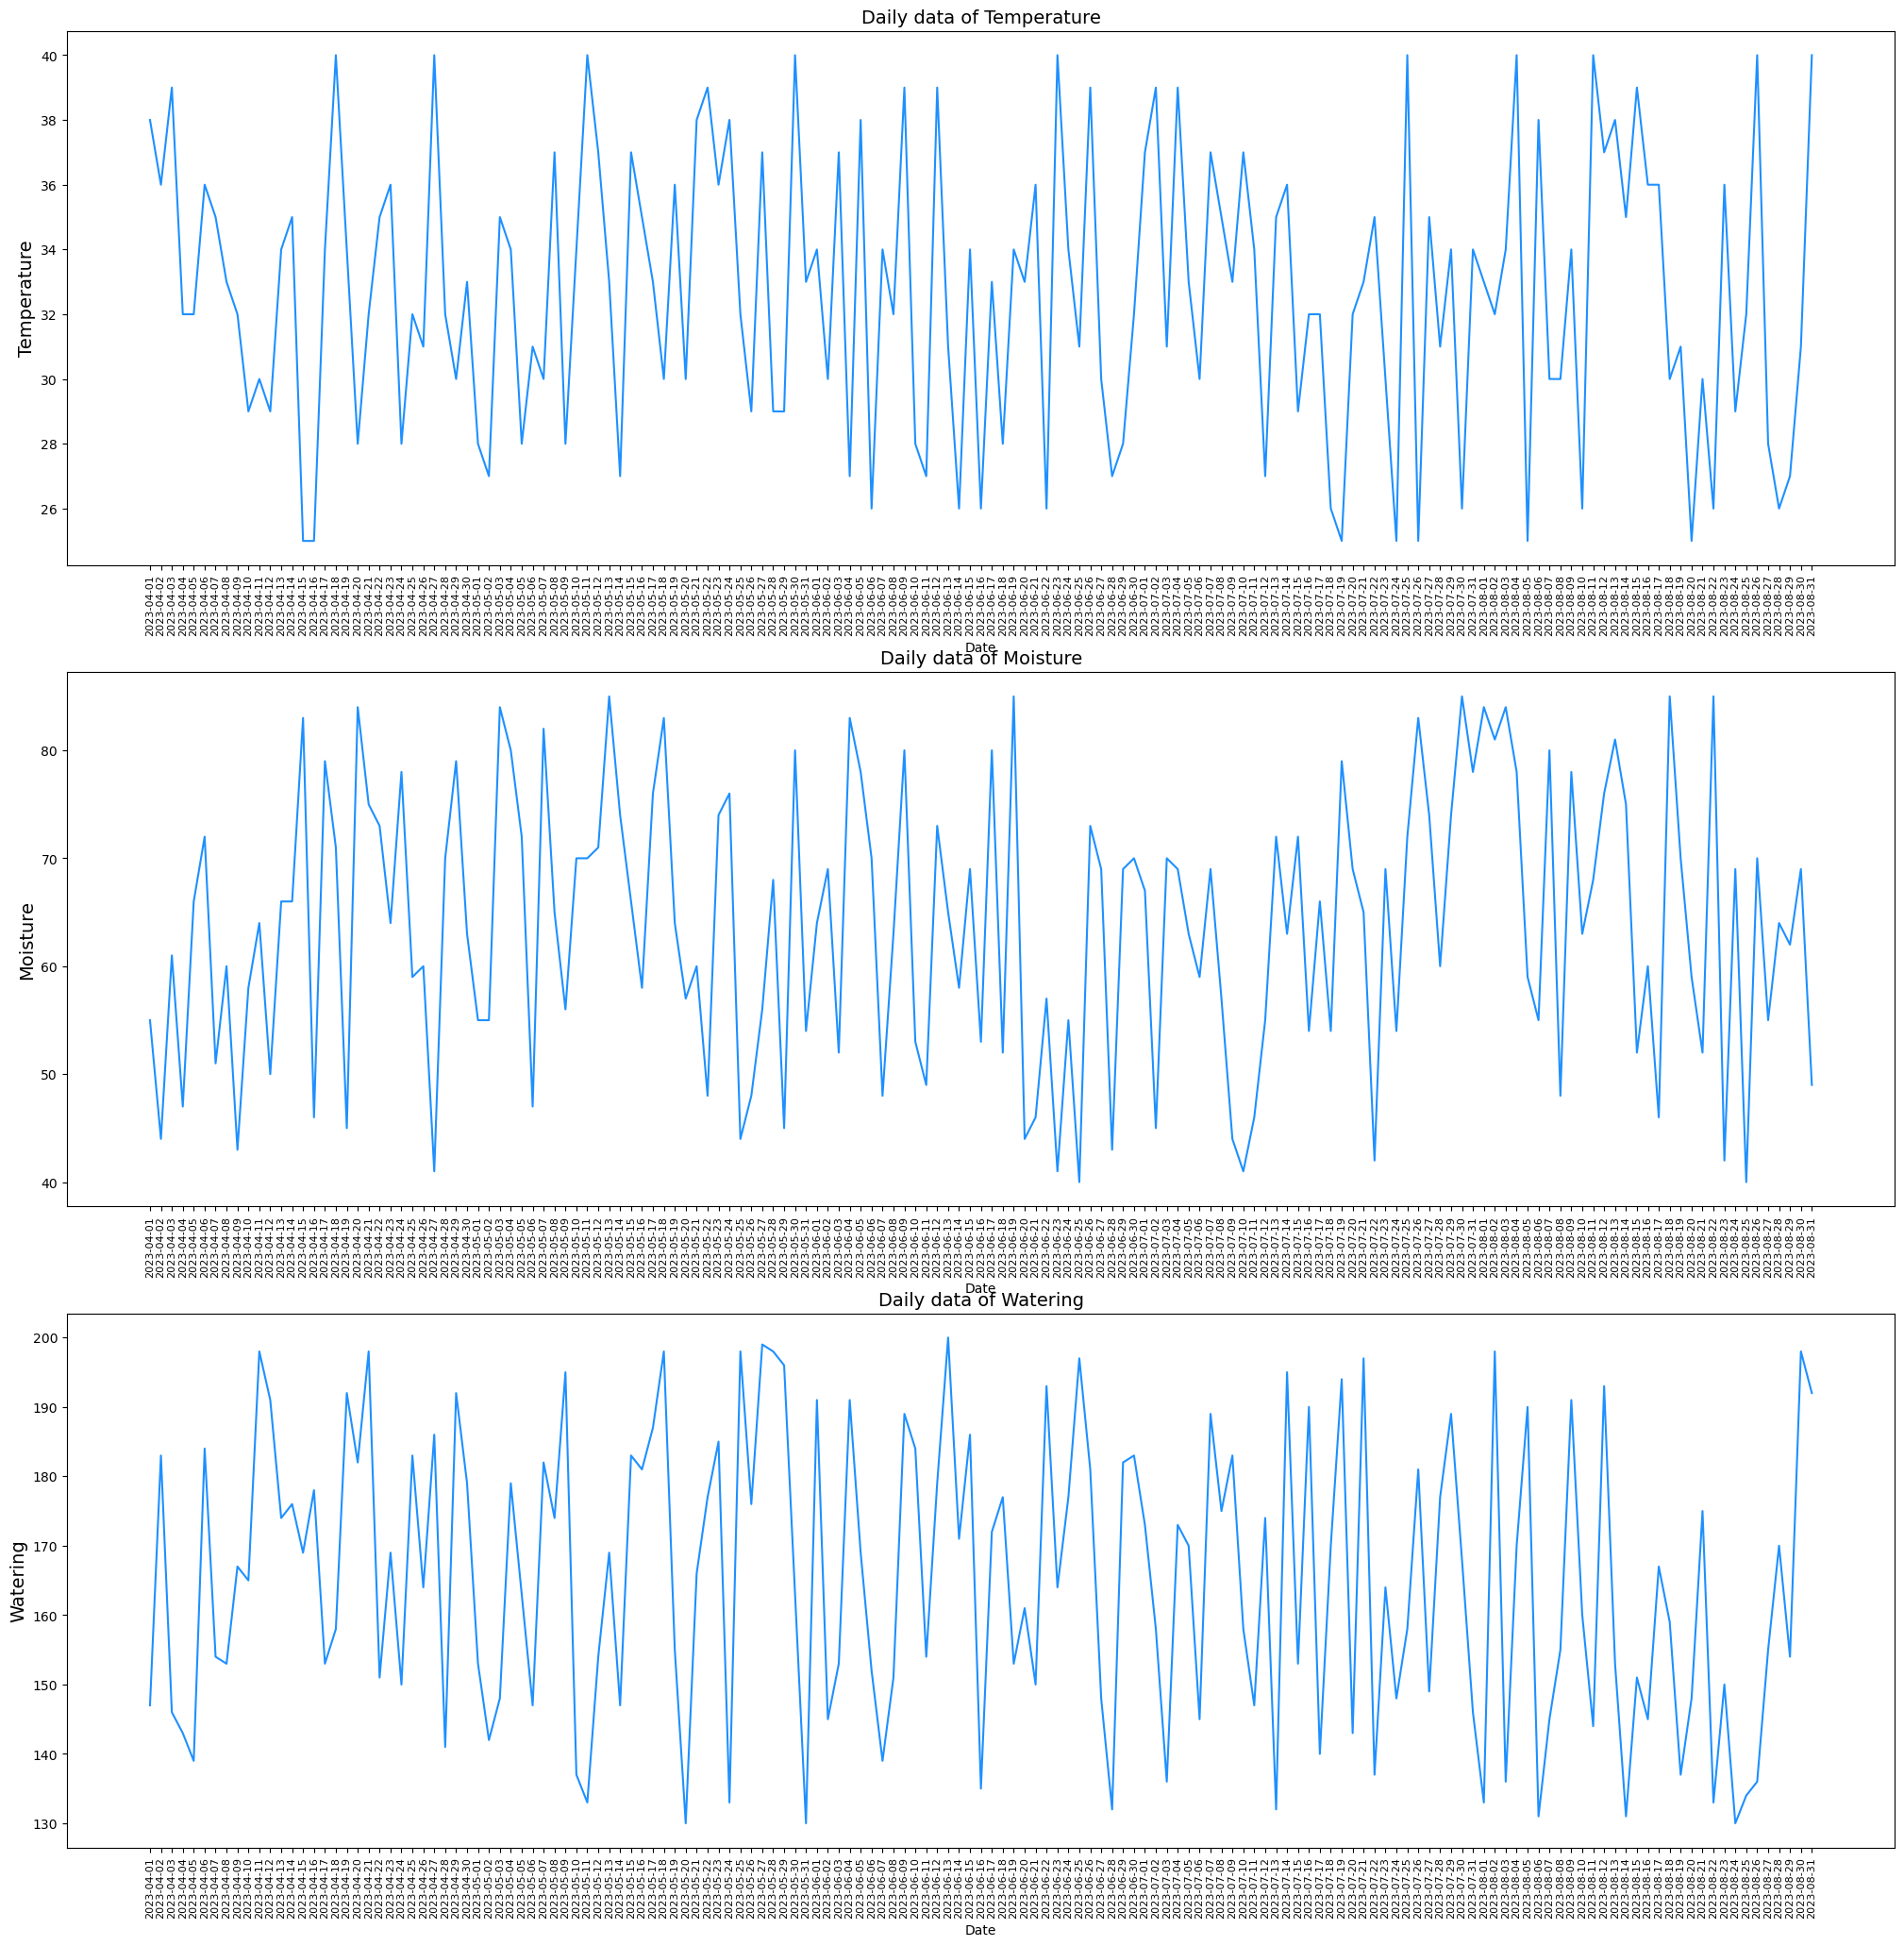

In [6]:
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(25, 25))

for i, column in enumerate(df.drop('Date', axis=1).columns):
    plot = sns.lineplot(x=df['Date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    plot.xaxis.set_major_locator(ticker.FixedLocator(plot.get_xticks()))
    ax[i].tick_params(axis='x', labelrotation=90, labelsize=8)
    ax[i].set_title('Daily data of {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    

    



In [7]:
df.columns

Index(['Date', 'Temperature', 'Moisture', 'Watering'], dtype='object')

<AxesSubplot:>

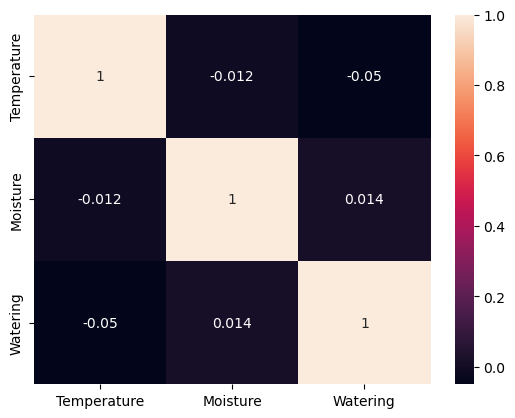

In [8]:
sns.heatmap(df.corr(), annot=True, )

In [9]:
def date_features(df, label):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])

    df['date'] = df.Date
    df['month'] = df['date'].dt.strftime('%B')
    df['year'] = df['date'].dt.strftime('%Y')
    df['dayofweek'] = df['date'].dt.strftime('%A')
    df['quarter'] = df['date'].dt.quarter
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    y=df[label]
    return X, y


In [10]:
X, y = date_features(df, label='Moisture')
df_moist = pd.concat([X, y], axis=1)
df_moist

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Moisture
0,Saturday,2,April,2023,91,1,13,55
1,Sunday,2,April,2023,92,2,13,44
2,Monday,2,April,2023,93,3,14,61
3,Tuesday,2,April,2023,94,4,14,47
4,Wednesday,2,April,2023,95,5,14,66
...,...,...,...,...,...,...,...,...
148,Sunday,3,August,2023,239,27,34,55
149,Monday,3,August,2023,240,28,35,64
150,Tuesday,3,August,2023,241,29,35,62
151,Wednesday,3,August,2023,242,30,35,69


In [11]:
X, y = date_features(df, label='Temperature')
df_temp = pd.concat([X, y], axis=1)
df_temp

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Temperature
0,Saturday,2,April,2023,91,1,13,38
1,Sunday,2,April,2023,92,2,13,36
2,Monday,2,April,2023,93,3,14,39
3,Tuesday,2,April,2023,94,4,14,32
4,Wednesday,2,April,2023,95,5,14,32
...,...,...,...,...,...,...,...,...
148,Sunday,3,August,2023,239,27,34,28
149,Monday,3,August,2023,240,28,35,26
150,Tuesday,3,August,2023,241,29,35,27
151,Wednesday,3,August,2023,242,30,35,31


In [12]:
X, y = date_features(df, label='Watering')
df_water = pd.concat([X, y], axis=1)
df_water

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Watering
0,Saturday,2,April,2023,91,1,13,147
1,Sunday,2,April,2023,92,2,13,183
2,Monday,2,April,2023,93,3,14,146
3,Tuesday,2,April,2023,94,4,14,143
4,Wednesday,2,April,2023,95,5,14,139
...,...,...,...,...,...,...,...,...
148,Sunday,3,August,2023,239,27,34,155
149,Monday,3,August,2023,240,28,35,170
150,Tuesday,3,August,2023,241,29,35,154
151,Wednesday,3,August,2023,242,30,35,198


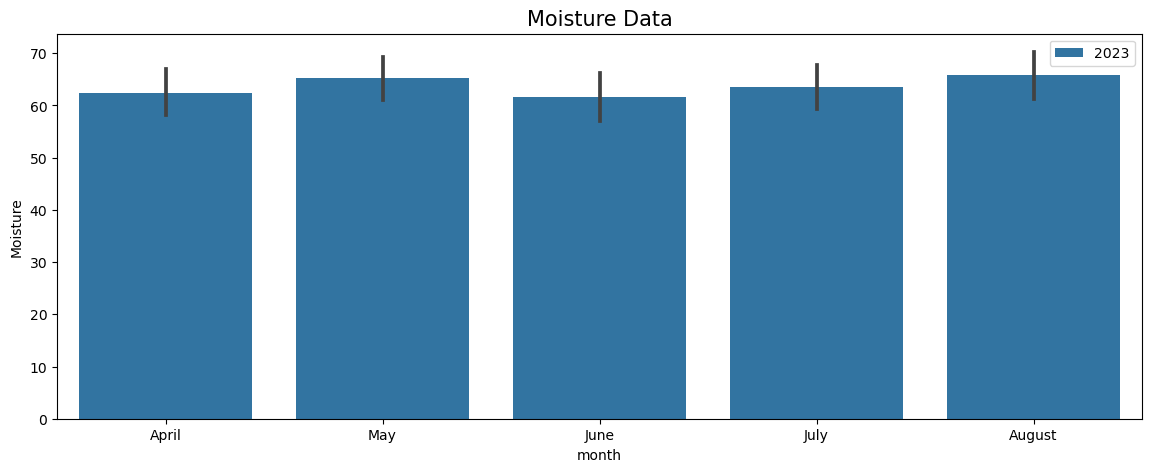

In [13]:
fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="month", y="Moisture",hue = 'year',data=df_moist)
a.set_title("Moisture Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

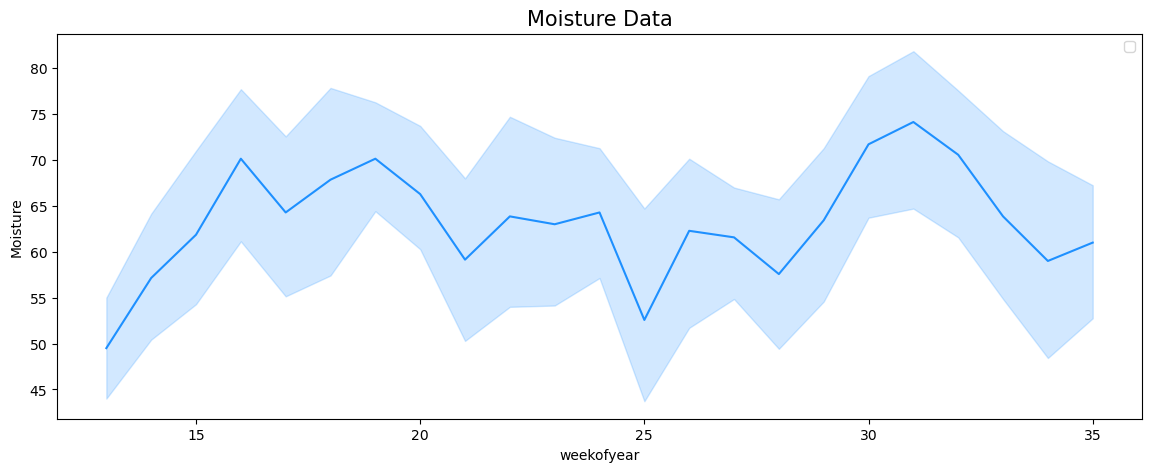

In [14]:

fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.lineplot(x=df_moist['weekofyear'], y=df_moist['Moisture'].fillna(method='ffill'), color='dodgerblue')
a.set_title("Moisture Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

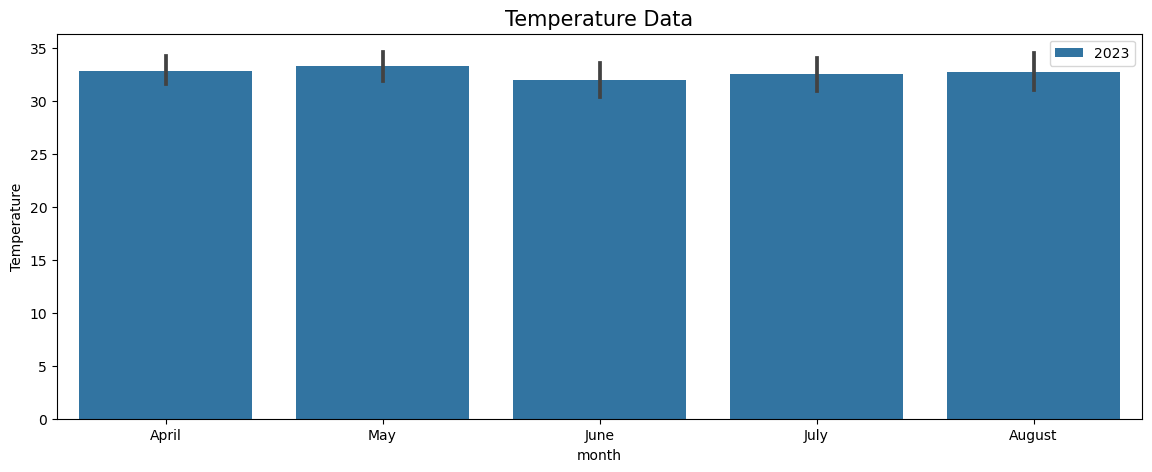

In [15]:
fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="month", y="Temperature",hue = 'year',data=df_temp)
a.set_title("Temperature Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

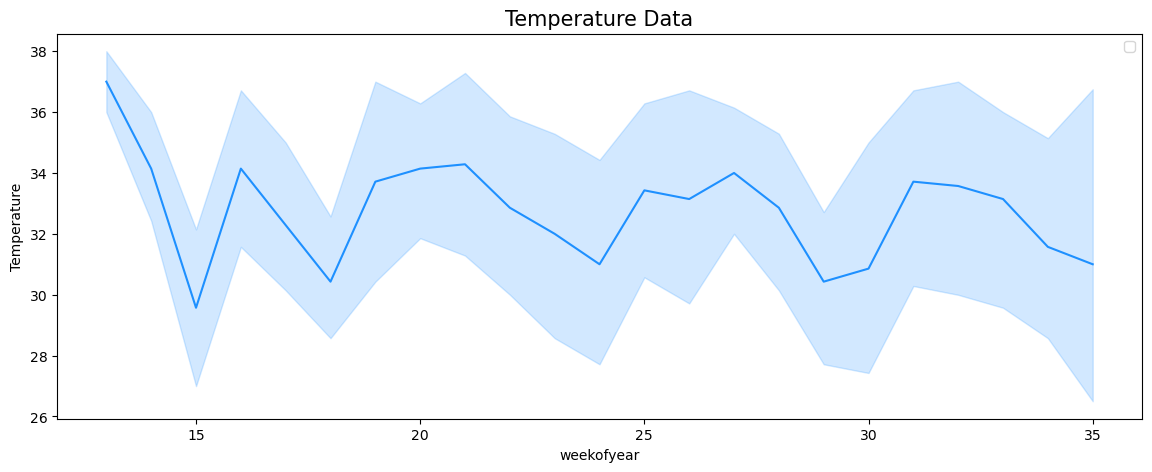

In [16]:

fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.lineplot(x=df_temp['weekofyear'], y=df_temp['Temperature'].fillna(method='ffill'), color='dodgerblue')
a.set_title("Temperature Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

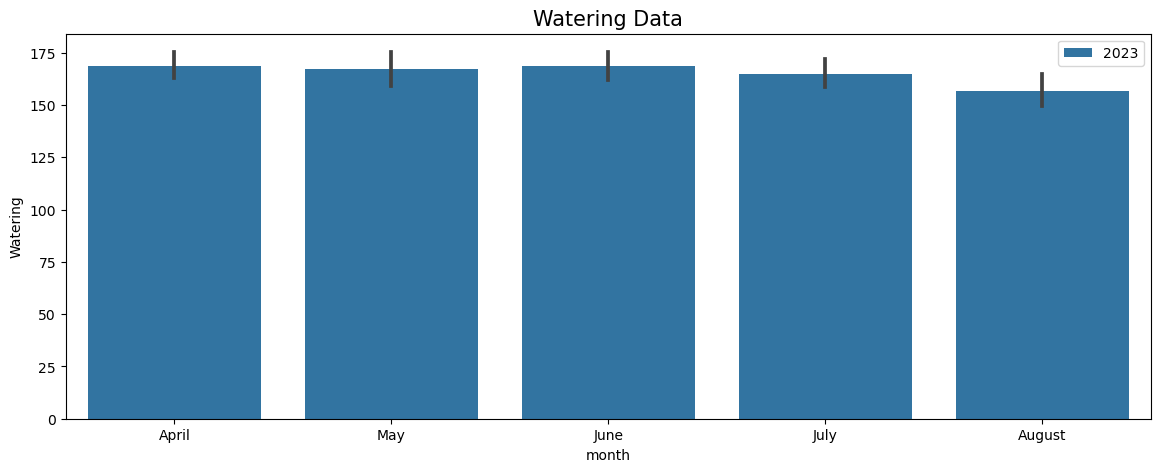

In [17]:
fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="month", y="Watering",hue = 'year',data=df_water)
a.set_title("Watering Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

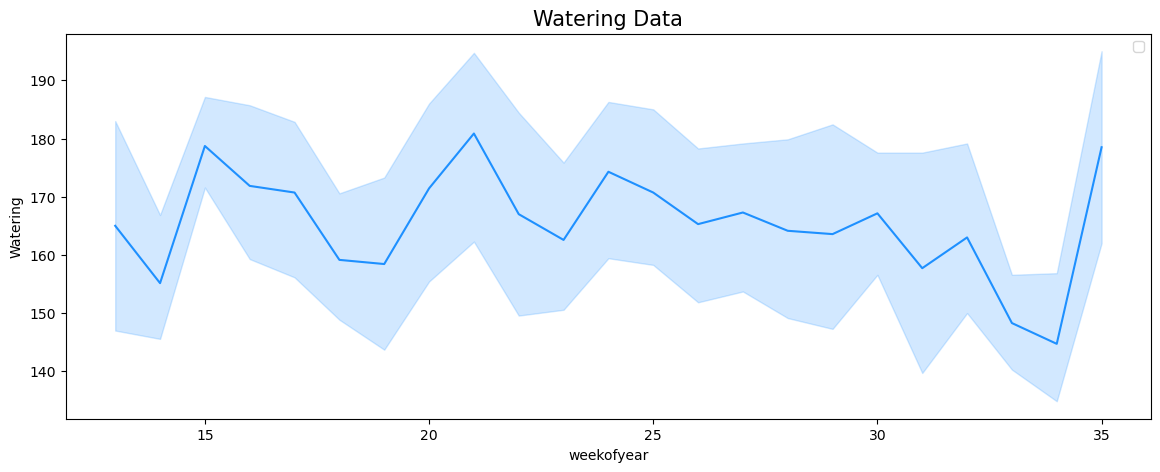

In [18]:

fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.lineplot(x=df_water['weekofyear'], y=df_water['Watering'].fillna(method='ffill'), color='dodgerblue')
a.set_title("Watering Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

<AxesSubplot:xlabel='Moisture', ylabel='Count'>

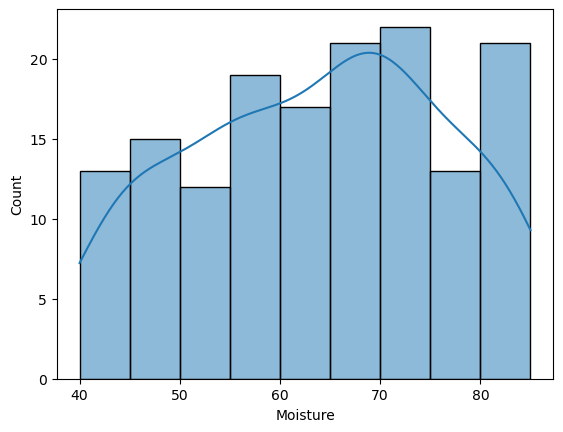

In [19]:
sns.histplot(x = df['Moisture'], kde = True)

<AxesSubplot:xlabel='Temperature', ylabel='Count'>

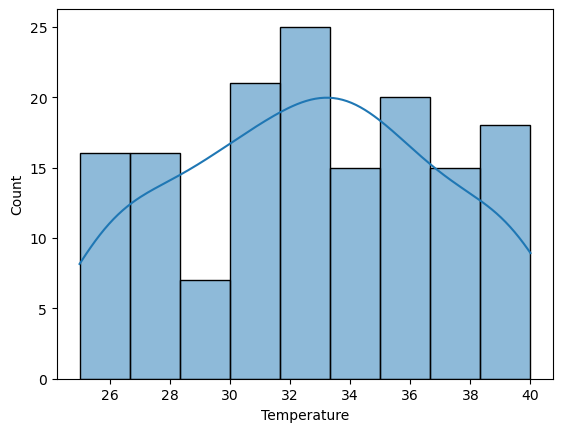

In [20]:
sns.histplot(x = df['Temperature'], kde = True)

<AxesSubplot:xlabel='Watering', ylabel='Count'>

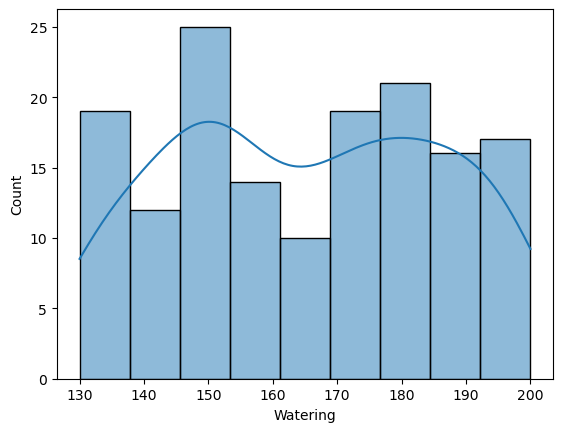

In [21]:
sns.histplot(x = df['Watering'], kde = True)

<AxesSubplot:>

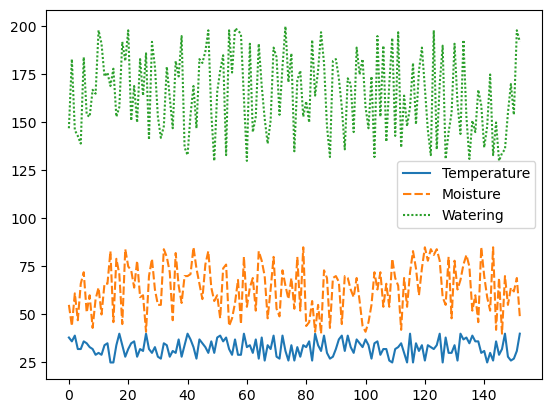

In [22]:
sns.lineplot(data=df)

## ***Data Preprocessing***

In [23]:
train_df.head()

,Date,Temperature,Moisture,Watering
0,2023-05-19,36,64,155
1,2023-04-26,31,60,164
2,2023-04-03,39,61,146
3,2023-04-22,35,73,151
4,2023-07-03,31,70,136


In [24]:
def data_process(data):
    df= data.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Quarter'] = df['Date'].dt.quarter
    df.drop(columns=['Date'], inplace=True)

    return df

In [25]:
train= data_process(train_df)
train.head()

,Temperature,Moisture,Watering,Year,Month,Day,DayOfWeek,Quarter
0,36,64,155,2023,5,19,4,2
1,31,60,164,2023,4,26,2,2
2,39,61,146,2023,4,3,0,2
3,35,73,151,2023,4,22,5,2
4,31,70,136,2023,7,3,0,3


In [26]:
test=  data_process(test_df)
test.head()

,Temperature,Moisture,Watering,Year,Month,Day,DayOfWeek,Quarter
0,39,73,181,2023,6,26,0,2
1,38,60,166,2023,5,21,6,2
2,34,84,136,2023,8,3,3,3
3,35,84,148,2023,5,3,2,2
4,37,41,158,2023,7,10,0,3


In [27]:
X = train[['Temperature', 'Moisture']]

y=  train['Watering']

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [29]:
test_x = test[['Temperature', 'Moisture']]
test_y = test['Watering']

# ***Linear Regression***


In [30]:
param_grid = {'fit_intercept': [True, False],
              
              'copy_X': [True, False]}

In [31]:
n_splits = 5

### ***1. Time series split & Grid Search***

In [32]:
tscv = TimeSeriesSplit(n_splits=n_splits)
model = LinearRegression()

In [33]:
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=tscv)

In [34]:
train.columns

Index(['Temperature', 'Moisture', 'Watering', 'Year', 'Month', 'Day',
       'DayOfWeek', 'Quarter'],
      dtype='object')

In [35]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False]},
             scoring='neg_mean_squared_error')

In [36]:
print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'copy_X': True, 'fit_intercept': True}


In [37]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

In [38]:
mse = mean_squared_error(y_val, y_pred)
print("Mean squared error: ", mse)

Mean squared error:  508.86220903156334


### ***1.2 linear regression With KFOLD***

In [39]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores_lr = []
for train_idx, val_idx in kf.split(X_train, y_train):
    X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    # train linear regression model
    
    best_model.fit(X_train_fold, y_train_fold)
    
    # evaluate the model on validation set
    y_val_pred = best_model.predict(X_val_fold)
    mse_scores_lr.append(mean_squared_error(y_val_fold, y_val_pred))

In [40]:
print(mse_scores_lr)

[289.3211644446353, 363.8720955354393, 372.74203934839574, 319.53837105786334, 487.1189935290457]


In [41]:
avg_mse_score_lr = sum(mse_scores_lr) / len(mse_scores_lr)

In [42]:
print(avg_mse_score_lr)

366.5185327830759


In [43]:
predicted_df_lr = test_df.copy()
pred_value= best_model.predict(test_x)
predicted_df_lr['pred_value']= pred_value
predicted_df_lr.head()

,Date,Temperature,Moisture,Watering,pred_value
0,2023-06-26,39,73,181,163.333610
1,2023-05-21,38,60,166,163.536865
2,2023-08-03,34,84,136,165.025108
3,2023-05-03,35,84,148,164.706354
4,2023-07-10,37,41,158,163.686814


In [44]:
mean_squared_error(pred_value, test_y)

579.8028244160693

# ***Decision Tree Regression***

In [45]:
from sklearn.tree import DecisionTreeRegressor


In [46]:
!pip install Optuna

In [47]:
import optuna

In [48]:
def objective(trial, data=X, target=y):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.18,random_state=3317)
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 32),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0)
    }

    model = DecisionTreeRegressor(**params)
    model.fit(train_x,train_y)
    
    preds = model.predict(test_x)
    mse = mean_squared_error(test_y, preds,squared=False)
    
    return mse

In [49]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-04-02 09:09:05,311] A new study created in memory with name: no-name-b55bd8db-12f3-41ea-9c6f-b111bcb84599
[I 2023-04-02 09:09:05,324] Trial 0 finished with value: 23.025621044309005 and parameters: {'max_depth': 28, 'min_samples_split': 24, 'min_samples_leaf': 21, 'max_features': 0.22556823195557285}. Best is trial 0 with value: 23.025621044309005.
[I 2023-04-02 09:09:05,335] Trial 1 finished with value: 22.027653476814198 and parameters: {'max_depth': 5, 'min_samples_split': 23, 'min_samples_leaf': 31, 'max_features': 0.31240295089910447}. Best is trial 1 with value: 22.027653476814198.
[I 2023-04-02 09:09:05,344] Trial 2 finished with value: 22.603698143370387 and parameters: {'max_depth': 25, 'min_samples_split': 15, 'min_samples_leaf': 28, 'max_features': 0.1471832833381597}. Best is trial 1 with value: 22.027653476814198.
[I 2023-04-02 09:09:05,354] Trial 3 finished with value: 23.99870246317297 and parameters: {'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 

Number of finished trials: 10
Best trial: {'max_depth': 5, 'min_samples_split': 23, 'min_samples_leaf': 31, 'max_features': 0.31240295089910447}


In [50]:
param = study.best_params

In [51]:

mse_scores_dt=[]
for train_idx, val_idx in kf.split(X_train, y_train):
    X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    # train linear regression model
    
    dec_model = DecisionTreeRegressor(**param)

    dec_model.fit(X_train_fold, y_train_fold)
    
    # evaluate the model on validation set
    y_val_pred = dec_model.predict(X_val_fold)
    mse_scores_dt.append(mean_squared_error(y_val_fold, y_val_pred))

In [52]:
mse_scores_dt

[306.1168519535369,
 369.4702048027757,
 379.6470140498606,
 326.8138597199451,
 488.96330001309434]

In [53]:
avg_mse_score_dt=sum(mse_scores_dt)/len(mse_scores_dt)

In [54]:
print(avg_mse_score_dt)

374.2022461078426


In [55]:
predicted_df_dt = test_df.copy()
pred_value_dt= dec_model.predict(test_x)
predicted_df_dt['pred_value']= pred_value_dt
predicted_df_dt.head()

,Date,Temperature,Moisture,Watering,pred_value
0,2023-06-26,39,73,181,164.176471
1,2023-05-21,38,60,166,166.068182
2,2023-08-03,34,84,136,164.176471
3,2023-05-03,35,84,148,164.176471
4,2023-07-10,37,41,158,166.068182


In [56]:
mean_squared_error(pred_value_dt, test_y)

576.9654662447568

# ***CAT Boost Regressor***

In [57]:
!pip install catboost

In [58]:
from catboost import CatBoostRegressor

In [59]:
def objective_cat(trial, data=X, target=y):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.18,random_state=3317)
    
    param = {
      
      "eval_metric": trial.suggest_categorical("loss_function", ["RMSE","MAE"]),
      'random_state': 48,
      'iterations': 3500,
      'sampling_frequency': "PerTree",
      'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
      'colsample_bylevel': trial.suggest_float('colsample_bylevel',0.3, 1.0),
      'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
      'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
      'depth': trial.suggest_categorical('max_depth', [2, 4, 6, 8, 14]),

      'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
      }
    

 
    model = CatBoostRegressor(**param)  
    
    model.fit(train_x,train_y)
    
    preds = model.predict(test_x)
    
    mse = mean_squared_error(test_y, preds,squared=False)
    
    return mse

In [60]:
study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective_cat, n_trials=10)
print('Number of finished trials:', len(study_cat.trials))
print('Best trial:', study_cat.best_trial.params)

[I 2023-04-02 09:09:18,862] A new study created in memory with name: no-name-ab263662-4a45-46c7-998c-43cefa926092
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


0:	learn: 16.5558145	total: 57.4ms	remaining: 3m 20s
1:	learn: 16.5436225	total: 57.7ms	remaining: 1m 40s
2:	learn: 16.5433133	total: 57.8ms	remaining: 1m 7s
3:	learn: 16.5399370	total: 57.8ms	remaining: 50.6s
4:	learn: 16.5381810	total: 57.9ms	remaining: 40.5s
5:	learn: 16.5364111	total: 57.9ms	remaining: 33.7s
6:	learn: 16.5267377	total: 58ms	remaining: 29s
7:	learn: 16.5236422	total: 58.1ms	remaining: 25.3s
8:	learn: 16.5083865	total: 58.2ms	remaining: 22.6s
9:	learn: 16.5035816	total: 58.3ms	remaining: 20.3s
10:	learn: 16.4935877	total: 58.4ms	remaining: 18.5s
11:	learn: 16.4915244	total: 58.5ms	remaining: 17s
12:	learn: 16.4796014	total: 58.6ms	remaining: 15.7s
13:	learn: 16.4796014	total: 58.6ms	remaining: 14.6s
14:	learn: 16.4688517	total: 58.7ms	remaining: 13.6s
15:	learn: 16.4658682	total: 58.8ms	remaining: 12.8s
16:	learn: 16.4658682	total: 58.8ms	remaining: 12s
17:	learn: 16.4637434	total: 58.8ms	remaining: 11.4s
18:	learn: 16.4484673	total: 59ms	remaining: 10.8s
19:	learn: 

[I 2023-04-02 09:09:19,514] Trial 0 finished with value: 25.840862708100342 and parameters: {'loss_function': 'MAE', 'reg_lambda': 0.0010728685158885416, 'colsample_bylevel': 0.5405160057447475, 'subsample': 1.0, 'learning_rate': 0.006, 'max_depth': 6, 'min_child_samples': 257}. Best is trial 0 with value: 25.840862708100342.


2988:	learn: 7.8515889	total: 320ms	remaining: 54.7ms
2989:	learn: 7.8494784	total: 322ms	remaining: 54.9ms
2990:	learn: 7.8492521	total: 322ms	remaining: 54.8ms
2991:	learn: 7.8491067	total: 322ms	remaining: 54.7ms
2992:	learn: 7.8491067	total: 322ms	remaining: 54.6ms
2993:	learn: 7.8479021	total: 322ms	remaining: 54.5ms
2994:	learn: 7.8475034	total: 322ms	remaining: 54.3ms
2995:	learn: 7.8475034	total: 322ms	remaining: 54.2ms
2996:	learn: 7.8475034	total: 322ms	remaining: 54.1ms
2997:	learn: 7.8475034	total: 322ms	remaining: 54ms
2998:	learn: 7.8471434	total: 322ms	remaining: 53.9ms
2999:	learn: 7.8429995	total: 323ms	remaining: 53.8ms
3000:	learn: 7.8429197	total: 323ms	remaining: 53.7ms
3001:	learn: 7.8411963	total: 323ms	remaining: 53.6ms
3002:	learn: 7.8368048	total: 323ms	remaining: 53.5ms
3003:	learn: 7.8368336	total: 323ms	remaining: 53.3ms
3004:	learn: 7.8368336	total: 323ms	remaining: 53.2ms
3005:	learn: 7.8337638	total: 323ms	remaining: 53.1ms
3006:	learn: 7.8336847	total: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


697:	learn: 14.8740260	total: 39.2ms	remaining: 157ms
698:	learn: 14.8740260	total: 39.7ms	remaining: 159ms
699:	learn: 14.8623533	total: 40ms	remaining: 160ms
700:	learn: 14.8499352	total: 40.1ms	remaining: 160ms
701:	learn: 14.8499352	total: 40.1ms	remaining: 160ms
702:	learn: 14.8460782	total: 40.3ms	remaining: 160ms
703:	learn: 14.8455117	total: 40.4ms	remaining: 160ms
704:	learn: 14.8455117	total: 40.4ms	remaining: 160ms
705:	learn: 14.8378016	total: 40.6ms	remaining: 161ms
706:	learn: 14.8372476	total: 40.7ms	remaining: 161ms
707:	learn: 14.8372476	total: 40.7ms	remaining: 161ms
708:	learn: 14.8299860	total: 40.9ms	remaining: 161ms
709:	learn: 14.8299860	total: 40.9ms	remaining: 161ms
710:	learn: 14.8280056	total: 41ms	remaining: 161ms
711:	learn: 14.8280056	total: 41.1ms	remaining: 161ms
712:	learn: 14.8275783	total: 41.1ms	remaining: 161ms
713:	learn: 14.8036858	total: 41.3ms	remaining: 161ms
714:	learn: 14.7879057	total: 41.4ms	remaining: 161ms
715:	learn: 14.7879057	total: 41

[I 2023-04-02 09:09:19,993] Trial 1 finished with value: 26.29951324761055 and parameters: {'loss_function': 'RMSE', 'reg_lambda': 0.1205676496190791, 'colsample_bylevel': 0.435446312410535, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 4, 'min_child_samples': 188}. Best is trial 0 with value: 25.840862708100342.


2412:	learn: 9.5999894	total: 162ms	remaining: 73ms
2413:	learn: 9.5988014	total: 163ms	remaining: 73.3ms
2414:	learn: 9.5988014	total: 163ms	remaining: 73.3ms
2415:	learn: 9.5986663	total: 163ms	remaining: 73.2ms
2416:	learn: 9.5986344	total: 163ms	remaining: 73.1ms
2417:	learn: 9.5986344	total: 163ms	remaining: 73ms
2418:	learn: 9.5986058	total: 163ms	remaining: 73ms
2419:	learn: 9.5984807	total: 163ms	remaining: 72.9ms
2420:	learn: 9.5984807	total: 163ms	remaining: 72.8ms
2421:	learn: 9.5984080	total: 163ms	remaining: 72.7ms
2422:	learn: 9.5968764	total: 163ms	remaining: 72.7ms
2423:	learn: 9.5968285	total: 163ms	remaining: 72.6ms
2424:	learn: 9.5968058	total: 164ms	remaining: 72.5ms
2425:	learn: 9.5965966	total: 164ms	remaining: 72.4ms
2426:	learn: 9.5949033	total: 164ms	remaining: 72.3ms
2427:	learn: 9.5949033	total: 164ms	remaining: 72.2ms
2428:	learn: 9.5942966	total: 164ms	remaining: 72.2ms
2429:	learn: 9.5942288	total: 164ms	remaining: 72.1ms
2430:	learn: 9.5941203	total: 164m

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


0:	learn: 18.9877898	total: 162us	remaining: 567ms
1:	learn: 18.9161507	total: 2.92ms	remaining: 5.1s
2:	learn: 18.8879413	total: 3.03ms	remaining: 3.53s
3:	learn: 18.8261032	total: 3.42ms	remaining: 2.99s
4:	learn: 18.8172008	total: 3.48ms	remaining: 2.43s
5:	learn: 18.7666617	total: 3.62ms	remaining: 2.11s
6:	learn: 18.7200653	total: 3.94ms	remaining: 1.97s
7:	learn: 18.7134295	total: 4ms	remaining: 1.75s
8:	learn: 18.7133977	total: 4.08ms	remaining: 1.58s
9:	learn: 18.7120672	total: 4.21ms	remaining: 1.47s
10:	learn: 18.7120672	total: 4.24ms	remaining: 1.34s
11:	learn: 18.6577735	total: 4.47ms	remaining: 1.3s
12:	learn: 18.6496579	total: 4.57ms	remaining: 1.23s
13:	learn: 18.6496579	total: 4.62ms	remaining: 1.15s
14:	learn: 18.6382326	total: 4.69ms	remaining: 1.09s
15:	learn: 18.6161038	total: 4.8ms	remaining: 1.05s
16:	learn: 18.6161038	total: 4.84ms	remaining: 992ms
17:	learn: 18.6026986	total: 4.9ms	remaining: 949ms
18:	learn: 18.4701151	total: 24.4ms	remaining: 4.46s
19:	learn: 

[I 2023-04-02 09:09:30,498] Trial 2 finished with value: 29.120098797767977 and parameters: {'loss_function': 'RMSE', 'reg_lambda': 0.021491267426615838, 'colsample_bylevel': 0.6673280868684734, 'subsample': 0.7, 'learning_rate': 0.017, 'max_depth': 14, 'min_child_samples': 193}. Best is trial 0 with value: 25.840862708100342.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


0:	learn: 16.5221290	total: 467us	remaining: 1.64s
1:	learn: 16.4912744	total: 1.14ms	remaining: 2s
2:	learn: 16.4091670	total: 1.6ms	remaining: 1.86s
3:	learn: 16.3395960	total: 2.07ms	remaining: 1.81s
4:	learn: 16.2893162	total: 2.45ms	remaining: 1.71s
5:	learn: 16.2399101	total: 2.96ms	remaining: 1.73s
6:	learn: 16.1662073	total: 3.5ms	remaining: 1.75s
7:	learn: 16.0987459	total: 4.02ms	remaining: 1.75s
8:	learn: 16.0293325	total: 4.44ms	remaining: 1.72s
9:	learn: 16.0005989	total: 4.62ms	remaining: 1.61s
10:	learn: 15.9532823	total: 4.87ms	remaining: 1.54s
11:	learn: 15.8812144	total: 5.3ms	remaining: 1.54s
12:	learn: 15.7906041	total: 5.72ms	remaining: 1.53s
13:	learn: 15.7535164	total: 5.99ms	remaining: 1.49s
14:	learn: 15.7167478	total: 6.46ms	remaining: 1.5s
15:	learn: 15.6831169	total: 7.01ms	remaining: 1.52s
16:	learn: 15.6059437	total: 7.57ms	remaining: 1.55s
17:	learn: 15.5576607	total: 8.18ms	remaining: 1.58s
18:	learn: 15.5193967	total: 8.61ms	remaining: 1.58s
19:	learn: 

[I 2023-04-02 09:09:32,438] Trial 3 finished with value: 29.522350400600402 and parameters: {'loss_function': 'MAE', 'reg_lambda': 0.07110183537041452, 'colsample_bylevel': 0.9406114086565269, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 8, 'min_child_samples': 209}. Best is trial 0 with value: 25.840862708100342.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


0:	learn: 16.5597962	total: 203us	remaining: 711ms
1:	learn: 16.5159513	total: 1.92ms	remaining: 3.36s
2:	learn: 16.5148123	total: 2ms	remaining: 2.33s
3:	learn: 16.5148123	total: 2.06ms	remaining: 1.8s
4:	learn: 16.4546168	total: 3.87ms	remaining: 2.71s
5:	learn: 16.4507658	total: 4.08ms	remaining: 2.37s
6:	learn: 16.4187485	total: 4.59ms	remaining: 2.29s
7:	learn: 16.3927206	total: 5.18ms	remaining: 2.26s
8:	learn: 16.3927205	total: 5.25ms	remaining: 2.04s
9:	learn: 16.3573570	total: 5.59ms	remaining: 1.95s
10:	learn: 16.3527226	total: 5.69ms	remaining: 1.8s
11:	learn: 16.3207378	total: 6.08ms	remaining: 1.77s
12:	learn: 16.3207377	total: 6.13ms	remaining: 1.64s
13:	learn: 16.3144209	total: 6.28ms	remaining: 1.56s
14:	learn: 16.2504552	total: 15.6ms	remaining: 3.62s
15:	learn: 16.2423287	total: 15.8ms	remaining: 3.45s
16:	learn: 16.2423287	total: 15.9ms	remaining: 3.26s
17:	learn: 16.2330040	total: 16.2ms	remaining: 3.12s
18:	learn: 16.2265338	total: 16.3ms	remaining: 2.98s
19:	learn

[I 2023-04-02 09:09:43,290] Trial 4 finished with value: 28.911683719867515 and parameters: {'loss_function': 'MAE', 'reg_lambda': 0.006686013414912275, 'colsample_bylevel': 0.6812704526054512, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 14, 'min_child_samples': 251}. Best is trial 0 with value: 25.840862708100342.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


0:	learn: 18.9880520	total: 238us	remaining: 834ms
1:	learn: 18.9416193	total: 1.25ms	remaining: 2.18s
2:	learn: 18.8865727	total: 1.88ms	remaining: 2.19s
3:	learn: 18.8243538	total: 2.41ms	remaining: 2.11s
4:	learn: 18.7533819	total: 2.93ms	remaining: 2.05s
5:	learn: 18.7234070	total: 3.26ms	remaining: 1.9s
6:	learn: 18.7128292	total: 3.42ms	remaining: 1.71s
7:	learn: 18.6648038	total: 3.9ms	remaining: 1.7s
8:	learn: 18.6551652	total: 4.05ms	remaining: 1.57s
9:	learn: 18.6102863	total: 4.44ms	remaining: 1.55s
10:	learn: 18.5494096	total: 4.87ms	remaining: 1.54s
11:	learn: 18.5039299	total: 5.27ms	remaining: 1.53s
12:	learn: 18.4474297	total: 6.08ms	remaining: 1.63s
13:	learn: 18.4164215	total: 6.41ms	remaining: 1.6s
14:	learn: 18.3792223	total: 6.86ms	remaining: 1.59s
15:	learn: 18.3514562	total: 7.19ms	remaining: 1.56s
16:	learn: 18.3278008	total: 7.64ms	remaining: 1.56s
17:	learn: 18.3166140	total: 7.81ms	remaining: 1.51s
18:	learn: 18.2404291	total: 8.25ms	remaining: 1.51s
19:	lear

[I 2023-04-02 09:09:45,013] Trial 5 finished with value: 29.720721029285823 and parameters: {'loss_function': 'RMSE', 'reg_lambda': 0.0030001688760294353, 'colsample_bylevel': 0.8289341646905977, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 8, 'min_child_samples': 215}. Best is trial 0 with value: 25.840862708100342.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


0:	learn: 18.9880709	total: 161us	remaining: 567ms
1:	learn: 18.9814560	total: 761us	remaining: 1.33s
2:	learn: 18.9767827	total: 834us	remaining: 972ms
3:	learn: 18.9700151	total: 913us	remaining: 798ms
4:	learn: 18.9664642	total: 979us	remaining: 685ms
5:	learn: 18.9614886	total: 1.04ms	remaining: 604ms
6:	learn: 18.9569983	total: 1.08ms	remaining: 539ms
7:	learn: 18.9531541	total: 1.17ms	remaining: 509ms
8:	learn: 18.9402980	total: 1.22ms	remaining: 474ms
9:	learn: 18.9245365	total: 1.28ms	remaining: 449ms
10:	learn: 18.9245365	total: 1.32ms	remaining: 418ms
11:	learn: 18.9146037	total: 1.39ms	remaining: 403ms
12:	learn: 18.9068641	total: 1.46ms	remaining: 390ms
13:	learn: 18.9068641	total: 1.48ms	remaining: 369ms
14:	learn: 18.9000209	total: 1.56ms	remaining: 362ms
15:	learn: 18.8954699	total: 1.61ms	remaining: 351ms
16:	learn: 18.8903532	total: 1.69ms	remaining: 346ms
17:	learn: 18.8903532	total: 1.72ms	remaining: 332ms
18:	learn: 18.8783015	total: 1.78ms	remaining: 326ms
19:	lear

[I 2023-04-02 09:09:45,408] Trial 6 finished with value: 24.588480406947603 and parameters: {'loss_function': 'RMSE', 'reg_lambda': 0.6417476001162619, 'colsample_bylevel': 0.5673529703187872, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 2, 'min_child_samples': 225}. Best is trial 6 with value: 24.588480406947603.


2093:	learn: 14.6297336	total: 119ms	remaining: 80.2ms
2094:	learn: 14.6294857	total: 120ms	remaining: 80.4ms
2095:	learn: 14.6263146	total: 120ms	remaining: 80.3ms
2096:	learn: 14.6248231	total: 120ms	remaining: 80.3ms
2097:	learn: 14.6244843	total: 120ms	remaining: 80.3ms
2098:	learn: 14.6243714	total: 120ms	remaining: 80.3ms
2099:	learn: 14.6241763	total: 120ms	remaining: 80.2ms
2100:	learn: 14.6239914	total: 120ms	remaining: 80.2ms
2101:	learn: 14.6239914	total: 120ms	remaining: 80.1ms
2102:	learn: 14.6237516	total: 121ms	remaining: 80.1ms
2103:	learn: 14.6237123	total: 121ms	remaining: 80ms
2104:	learn: 14.6237123	total: 121ms	remaining: 79.9ms
2105:	learn: 14.6227686	total: 121ms	remaining: 79.9ms
2106:	learn: 14.6227686	total: 121ms	remaining: 79.8ms
2107:	learn: 14.6227686	total: 121ms	remaining: 79.8ms
2108:	learn: 14.6200970	total: 121ms	remaining: 79.8ms
2109:	learn: 14.6198553	total: 121ms	remaining: 79.7ms
2110:	learn: 14.6177437	total: 121ms	remaining: 79.7ms
2111:	learn:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


14:	learn: 18.8006934	total: 1.94ms	remaining: 451ms
15:	learn: 18.7872086	total: 3.13ms	remaining: 682ms
16:	learn: 18.7775789	total: 5.14ms	remaining: 1.05s
17:	learn: 18.7634428	total: 5.29ms	remaining: 1.02s
18:	learn: 18.7578336	total: 5.49ms	remaining: 1s
19:	learn: 18.7448917	total: 5.64ms	remaining: 981ms
20:	learn: 18.7321191	total: 5.78ms	remaining: 958ms
21:	learn: 18.7250624	total: 5.97ms	remaining: 944ms
22:	learn: 18.7103065	total: 6.12ms	remaining: 926ms
23:	learn: 18.6958354	total: 6.28ms	remaining: 909ms
24:	learn: 18.6925114	total: 6.42ms	remaining: 892ms
25:	learn: 18.6873659	total: 6.58ms	remaining: 879ms
26:	learn: 18.6739780	total: 6.76ms	remaining: 869ms
27:	learn: 18.6605029	total: 6.91ms	remaining: 857ms
28:	learn: 18.6556157	total: 7.07ms	remaining: 846ms
29:	learn: 18.6221389	total: 7.21ms	remaining: 834ms
30:	learn: 18.6117464	total: 7.35ms	remaining: 823ms
31:	learn: 18.5896129	total: 7.52ms	remaining: 815ms
32:	learn: 18.5724702	total: 7.68ms	remaining: 80

[I 2023-04-02 09:09:46,137] Trial 7 finished with value: 26.678931867162092 and parameters: {'loss_function': 'RMSE', 'reg_lambda': 0.22212633747412655, 'colsample_bylevel': 0.9502244517299814, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_samples': 213}. Best is trial 6 with value: 24.588480406947603.


3301:	learn: 7.5338766	total: 435ms	remaining: 26.1ms
3302:	learn: 7.5330291	total: 436ms	remaining: 26ms
3303:	learn: 7.5324383	total: 437ms	remaining: 25.9ms
3304:	learn: 7.5316109	total: 437ms	remaining: 25.8ms
3305:	learn: 7.5290234	total: 437ms	remaining: 25.6ms
3306:	learn: 7.5278538	total: 437ms	remaining: 25.5ms
3307:	learn: 7.5274124	total: 437ms	remaining: 25.4ms
3308:	learn: 7.5242010	total: 437ms	remaining: 25.2ms
3309:	learn: 7.5233979	total: 438ms	remaining: 25.1ms
3310:	learn: 7.5230081	total: 438ms	remaining: 25ms
3311:	learn: 7.5203658	total: 438ms	remaining: 24.9ms
3312:	learn: 7.5194814	total: 438ms	remaining: 24.7ms
3313:	learn: 7.5173380	total: 438ms	remaining: 24.6ms
3314:	learn: 7.5172482	total: 438ms	remaining: 24.5ms
3315:	learn: 7.5163825	total: 439ms	remaining: 24.3ms
3316:	learn: 7.5129304	total: 439ms	remaining: 24.2ms
3317:	learn: 7.5115457	total: 439ms	remaining: 24.1ms
3318:	learn: 7.5085810	total: 439ms	remaining: 23.9ms
3319:	learn: 7.5080452	total: 43

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


452:	learn: 15.5120673	total: 56.5ms	remaining: 380ms
453:	learn: 15.5075082	total: 56.7ms	remaining: 381ms
454:	learn: 15.5055305	total: 56.9ms	remaining: 381ms
455:	learn: 15.5042653	total: 57ms	remaining: 381ms
456:	learn: 15.5006450	total: 57.2ms	remaining: 381ms
457:	learn: 15.5007380	total: 57.2ms	remaining: 380ms
458:	learn: 15.4989230	total: 57.4ms	remaining: 380ms
459:	learn: 15.4981153	total: 57.8ms	remaining: 382ms
460:	learn: 15.4956392	total: 58ms	remaining: 382ms
461:	learn: 15.4917848	total: 58.2ms	remaining: 382ms
462:	learn: 15.4901469	total: 58.3ms	remaining: 382ms
463:	learn: 15.4879366	total: 58.5ms	remaining: 382ms
464:	learn: 15.4841258	total: 59.1ms	remaining: 385ms
465:	learn: 15.4807704	total: 59.2ms	remaining: 386ms
466:	learn: 15.4781497	total: 59.4ms	remaining: 386ms
467:	learn: 15.4763617	total: 59.6ms	remaining: 386ms
468:	learn: 15.4757582	total: 59.7ms	remaining: 386ms
469:	learn: 15.4734430	total: 59.8ms	remaining: 386ms
470:	learn: 15.4720681	total: 60

[I 2023-04-02 09:09:46,952] Trial 8 finished with value: 25.08549950244347 and parameters: {'loss_function': 'MAE', 'reg_lambda': 8.393392397442076, 'colsample_bylevel': 0.7939370661770955, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': 4, 'min_child_samples': 25}. Best is trial 6 with value: 24.588480406947603.


3258:	learn: 11.6928592	total: 465ms	remaining: 34.4ms
3259:	learn: 11.6914088	total: 466ms	remaining: 34.3ms
3260:	learn: 11.6907678	total: 466ms	remaining: 34.2ms
3261:	learn: 11.6900125	total: 466ms	remaining: 34ms
3262:	learn: 11.6883582	total: 466ms	remaining: 33.9ms
3263:	learn: 11.6878110	total: 467ms	remaining: 33.7ms
3264:	learn: 11.6870847	total: 467ms	remaining: 33.6ms
3265:	learn: 11.6852635	total: 467ms	remaining: 33.5ms
3266:	learn: 11.6842959	total: 467ms	remaining: 33.3ms
3267:	learn: 11.6842815	total: 467ms	remaining: 33.2ms
3268:	learn: 11.6817025	total: 467ms	remaining: 33ms
3269:	learn: 11.6811201	total: 467ms	remaining: 32.9ms
3270:	learn: 11.6801449	total: 468ms	remaining: 32.7ms
3271:	learn: 11.6796329	total: 468ms	remaining: 32.6ms
3272:	learn: 11.6774797	total: 468ms	remaining: 32.4ms
3273:	learn: 11.6765452	total: 468ms	remaining: 32.3ms
3274:	learn: 11.6753010	total: 468ms	remaining: 32.2ms
3275:	learn: 11.6750363	total: 468ms	remaining: 32ms
3276:	learn: 11.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


666:	learn: 14.3692699	total: 50.8ms	remaining: 216ms
667:	learn: 14.3686627	total: 51.5ms	remaining: 218ms
668:	learn: 14.3668739	total: 51.6ms	remaining: 219ms
669:	learn: 14.3666150	total: 51.7ms	remaining: 219ms
670:	learn: 14.3624926	total: 51.8ms	remaining: 219ms
671:	learn: 14.3623125	total: 51.9ms	remaining: 219ms
672:	learn: 14.3572710	total: 52ms	remaining: 218ms
673:	learn: 14.3556516	total: 52.1ms	remaining: 218ms
674:	learn: 14.3545189	total: 52.2ms	remaining: 218ms
675:	learn: 14.3536195	total: 52.3ms	remaining: 218ms
676:	learn: 14.3487912	total: 52.4ms	remaining: 218ms
677:	learn: 14.3430935	total: 52.4ms	remaining: 218ms
678:	learn: 14.3433142	total: 52.5ms	remaining: 218ms
679:	learn: 14.3404569	total: 52.6ms	remaining: 218ms
680:	learn: 14.3406195	total: 52.7ms	remaining: 218ms
681:	learn: 14.3393294	total: 52.8ms	remaining: 218ms
682:	learn: 14.3390917	total: 52.9ms	remaining: 218ms
683:	learn: 14.3376629	total: 53ms	remaining: 218ms
684:	learn: 14.3320800	total: 53

[I 2023-04-02 09:09:47,398] Trial 9 finished with value: 24.50356418152894 and parameters: {'loss_function': 'MAE', 'reg_lambda': 0.20001154110612565, 'colsample_bylevel': 0.7513281380567003, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 2, 'min_child_samples': 268}. Best is trial 9 with value: 24.50356418152894.


2802:	learn: 11.5323854	total: 170ms	remaining: 42.3ms
2803:	learn: 11.5307463	total: 170ms	remaining: 42.3ms
2804:	learn: 11.5300896	total: 171ms	remaining: 42.4ms
2805:	learn: 11.5295663	total: 171ms	remaining: 42.4ms
2806:	learn: 11.5289624	total: 171ms	remaining: 42.3ms
2807:	learn: 11.5277888	total: 171ms	remaining: 42.2ms
2808:	learn: 11.5253931	total: 171ms	remaining: 42.2ms
2809:	learn: 11.5218293	total: 172ms	remaining: 42.1ms
2810:	learn: 11.5212823	total: 172ms	remaining: 42.1ms
2811:	learn: 11.5212824	total: 172ms	remaining: 42ms
2812:	learn: 11.5213058	total: 172ms	remaining: 41.9ms
2813:	learn: 11.5203027	total: 172ms	remaining: 41.9ms
2814:	learn: 11.5199242	total: 172ms	remaining: 41.8ms
2815:	learn: 11.5199243	total: 172ms	remaining: 41.7ms
2816:	learn: 11.5168899	total: 172ms	remaining: 41.7ms
2817:	learn: 11.5163886	total: 172ms	remaining: 41.6ms
2818:	learn: 11.5147458	total: 172ms	remaining: 41.5ms
2819:	learn: 11.5112559	total: 172ms	remaining: 41.5ms
2820:	learn:

In [61]:
param_cat = study_cat.best_params

In [62]:

mse_scores_cat=[]
for train_idx, val_idx in kf.split(X_train, y_train):
    X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    # train linear regression model
    
    xgb_model = CatBoostRegressor(**param_cat)

    xgb_model.fit(X_train_fold, y_train_fold)
    
    # evaluate the model on validation set
    y_val_pred = xgb_model.predict(X_val_fold)
    mse_scores_cat.append(mean_squared_error(y_val_fold, y_val_pred))

0:	learn: 16.5414796	total: 247us	remaining: 247ms
1:	learn: 16.5286068	total: 1.22ms	remaining: 609ms
2:	learn: 16.5273046	total: 1.32ms	remaining: 440ms
3:	learn: 16.5234955	total: 1.39ms	remaining: 347ms
4:	learn: 16.5223446	total: 1.5ms	remaining: 299ms
5:	learn: 16.5043104	total: 1.56ms	remaining: 258ms
6:	learn: 16.4930965	total: 1.66ms	remaining: 236ms
7:	learn: 16.4923439	total: 1.74ms	remaining: 216ms
8:	learn: 16.4902385	total: 1.81ms	remaining: 199ms
9:	learn: 16.4895953	total: 1.87ms	remaining: 185ms
10:	learn: 16.4894127	total: 1.92ms	remaining: 173ms
11:	learn: 16.4892052	total: 1.98ms	remaining: 163ms
12:	learn: 16.4890228	total: 2.04ms	remaining: 155ms
13:	learn: 16.4731842	total: 2.12ms	remaining: 149ms
14:	learn: 16.4694330	total: 2.2ms	remaining: 144ms
15:	learn: 16.4648831	total: 2.27ms	remaining: 139ms
16:	learn: 16.4648794	total: 2.31ms	remaining: 133ms
17:	learn: 16.4611546	total: 2.39ms	remaining: 130ms
18:	learn: 16.4563573	total: 2.45ms	remaining: 127ms
19:	le

In [63]:
avg_mse_score_cat=sum(mse_scores_cat)/len(mse_scores_cat)

print(avg_mse_score_cat)

473.7677815706214


In [64]:
predicted_df_cat = test_df.copy()
pred_value_cat= xgb_model.predict(test_x)
predicted_df_cat['pred_value']= pred_value_cat
predicted_df_cat.head()

,Date,Temperature,Moisture,Watering,pred_value
0,2023-06-26,39,73,181,164.744997
1,2023-05-21,38,60,166,165.529190
2,2023-08-03,34,84,136,160.661190
3,2023-05-03,35,84,148,156.721712
4,2023-07-10,37,41,158,165.555752


In [65]:
mean_squared_error(pred_value_cat, test_y)

582.3948096000435